In [1]:
%matplotlib widget
import testgear
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
import glob
import ipywidgets as widgets
import datetime
import time
import matplotlib

In [2]:
#F732C = 9.9999726 #18:00

# Daten einlesen

In [3]:
files = sorted(glob.glob("data/*_F732C_M69.xlsx"))

bar = widgets.IntProgress(
    value=0,
    min=0,
    max=len(files),
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'blue'},
    orientation='horizontal'
)

bar

IntProgress(value=0, description='Loading:', max=837, style=ProgressStyle(bar_color='blue'))

In [4]:
times  = []
values = []
stds   = []
temperature = []

for filename in files:
    bar.value +=1
    print(filename, end = "\r")
    data = pd.read_excel(filename)
    
    times.append(np.mean(data["timestamp"]))
    values.append(np.mean(data["diff"]*1e6))
    stds.append( 2 * np.std(data["diff"]*1e6)/len(data["diff"])**0.5  )
    #stds.append( np.std(data["diff"]*1e6) )
    temperature.append(np.mean(data["temp"]))

values = np.array(values)

In [5]:
# Zeitstempel in Sekunden umrechnen
ts = np.array([ (float(x.to_datetime64()) - float(times[0].to_datetime64())) * 1e-9 for x in times])

# Differenzen plotten

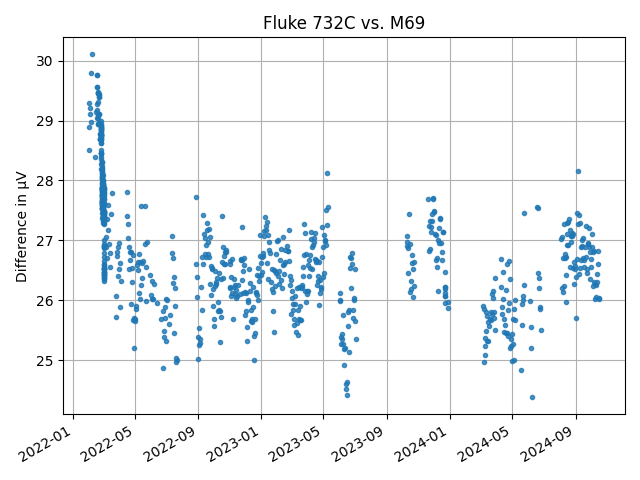

In [6]:
fig, ax = plt.subplots(1, 1, sharex=True)
plt.title("Fluke 732C vs. M69")

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
#ax.plot(times, values)
ax.plot(times, values, '.', alpha=0.8)
ax.set_ylabel("Difference in µV")
ax.grid()


fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig("M69.png", dpi=150)

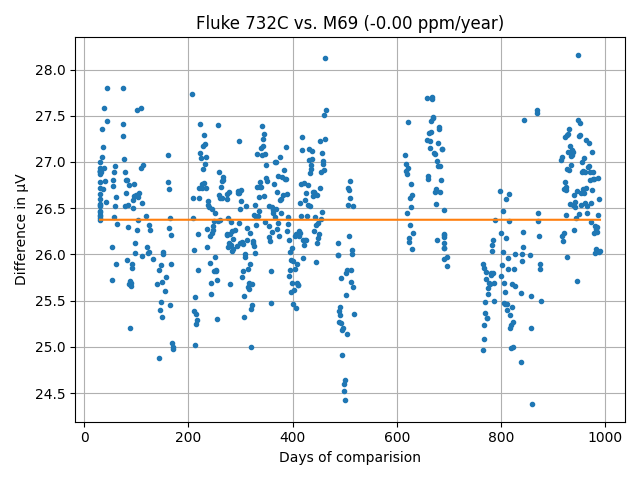

In [7]:
start=250
slope, intercept, rvalue, pvalue, stderr = stats.linregress(ts[start:], values[start:])

fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_title("Fluke 732C vs. M69 ({0:0.2f} ppm/year)".format(slope*3600*24*365 / 10))

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
#ax[0].plot(ts/3600, values)
ax.plot(ts[start:]/3600/24, values[start:], '.')
ax.plot(ts[start:]/3600/24, ts[start:]*slope + intercept)
ax.set_ylabel("Difference in µV")

ax.set_xlabel("Days of comparision")

ax.grid()


#fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig("M69_ltd.png", dpi=150)

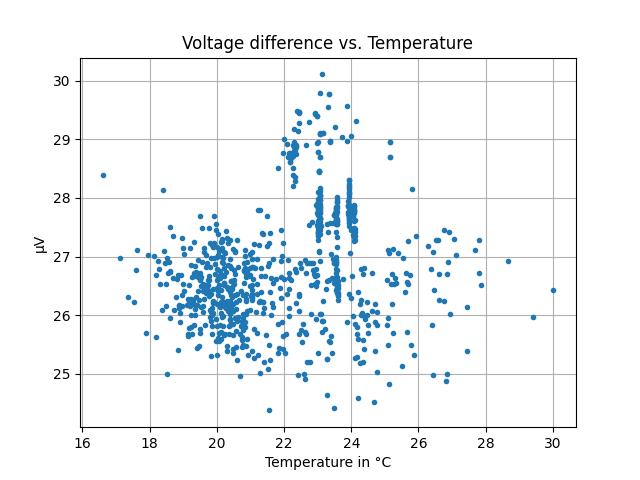

In [8]:
plt.figure()
plt.title("Voltage difference vs. Temperature")
plt.plot(temperature, values, '.')
plt.ylabel("µV")
plt.xlabel("Temperature in °C")
plt.grid()

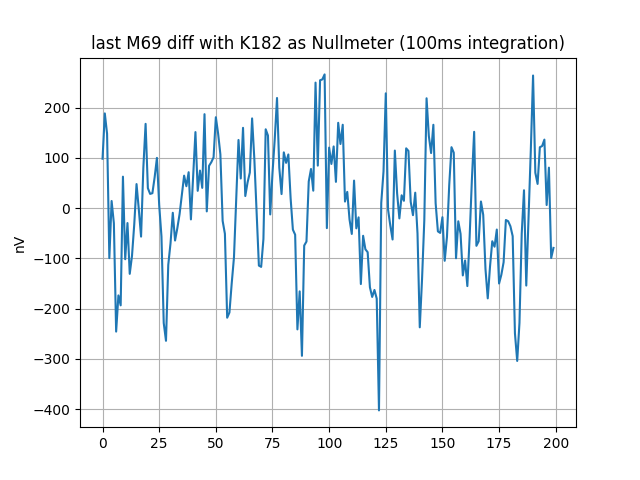

In [9]:
plt.figure()
plt.title("last M69 diff with K182 as Nullmeter (100ms integration)")
plt.plot( (data["diff"] - np.mean(data["diff"]) ) * 1e9 )
plt.ylabel("nV")
plt.grid()

# Offsetmessungen mit K182

In [10]:
otimes  = []
ovalues = []
ostds   = []
otemperature = []


for filename in sorted(glob.glob("data/*_offset.xlsx")):
    print(filename, end = "\r")
    data = pd.read_excel(filename)
    
    otimes.append(np.mean(data["timestamp"]))
    ovalues.append(np.mean(data["diff"]*1e9))
    ostds.append( 2 * np.std(data["diff"]*1e6)/len(data["diff"])**0.5  )
    #stds.append( np.std(data["diff"]*1e6) )
    otemperature.append(np.mean(data["temp"]))


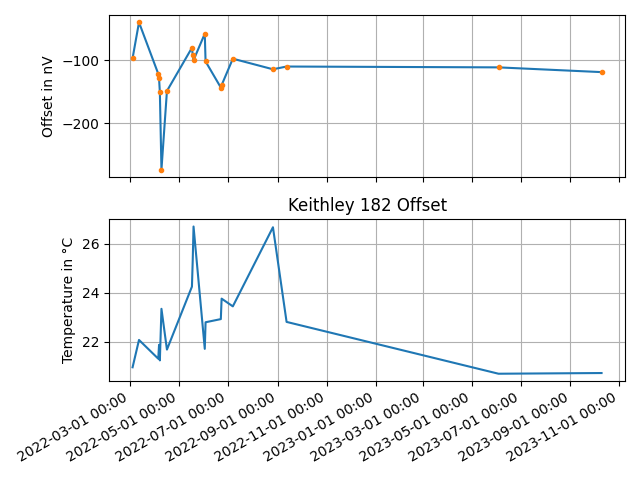

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.title("Keithley 182 Offset")

#ax[0].errorbar(times, values, yerr=stds, capsize=5)
ax[0].plot(otimes, ovalues)
ax[0].plot(otimes, ovalues, '.')
ax[0].set_ylabel("Offset in nV")
ax[0].grid()

ax[1].plot(otimes, otemperature)
ax[1].set_ylabel("Temperature in °C")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax[1].grid()


fig.autofmt_xdate()
plt.tight_layout()

# Fluke 732C Kalibrierdaten einlesen

In [12]:
fluke732c = pd.read_excel("Fluke_732C.xlsx")
fluke732c

,cal date,days,value,uncertainty,deviation (ppm)
0,2021-07-13,0,9.999975,NaN,0.000000
1,2022-05-17,308,9.999973,NaN,0.280001
2,2023-05-31,687,9.999969,0.1,0.350001
3,2024-07-18,1101,9.999966,0.1,0.350001


In [13]:
t_f732c = np.array([ (float(x.to_datetime64()) - float(times[0].to_datetime64())) * 1e-9 for x in fluke732c["cal date"]])
m_f732c, b_f732c, rvalue, pvalue, stderr = stats.linregress(t_f732c, fluke732c["value"])

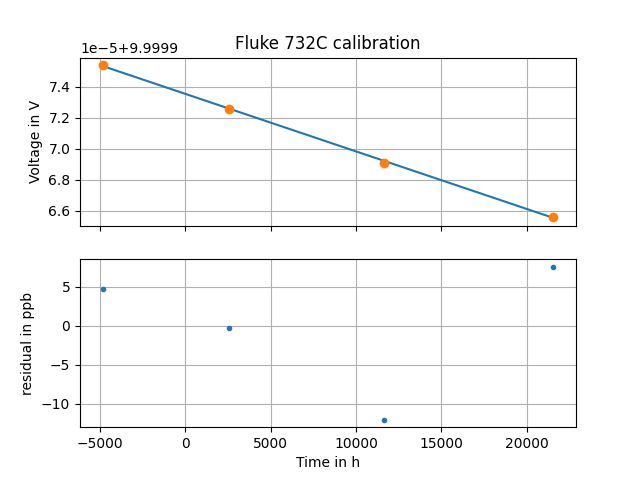

In [14]:
fit_error = (fluke732c["value"] - (t_f732c*m_f732c + b_f732c)) / 10 * 1e9

f732c_value = ts * m_f732c + b_f732c

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("Fluke 732C calibration")
ax[0].plot(t_f732c/3600, t_f732c*m_f732c + b_f732c)
ax[0].plot(t_f732c/3600, fluke732c["value"], 'o')
ax[0].set_ylabel("Voltage in V")
ax[0].grid()

ax[1].set_ylabel("residual in ppb")
ax[1].plot(t_f732c/3600, fit_error, '.')
ax[1].set_xlabel("Time in h")
ax[1].grid()


# Absolute Spannung M69

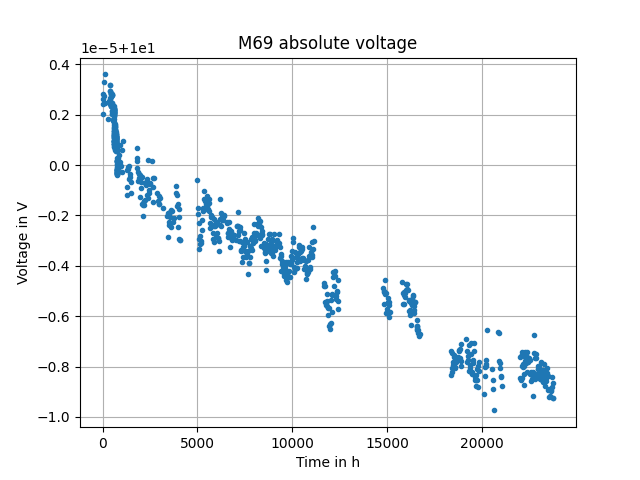

In [15]:
m69_value   = f732c_value + values*1e-6

plt.figure()
plt.title("M69 absolute voltage")
plt.plot(ts/3600, m69_value, '.')
plt.ylabel("Voltage in V")
plt.xlabel("Time in h")
plt.grid()

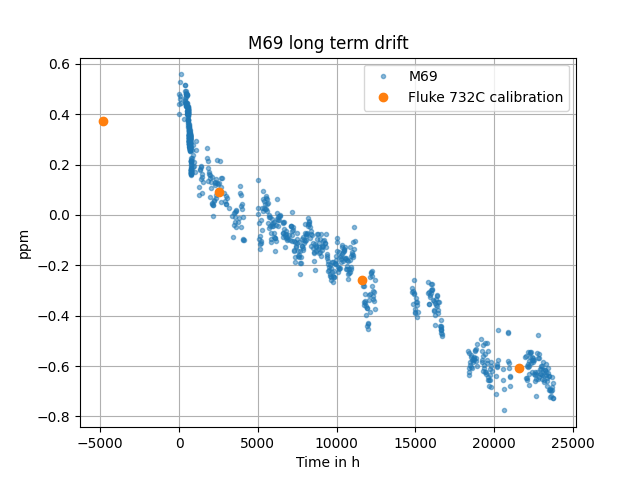

In [16]:
m69_ref   = 9.99999802
f732c_ref = 5000*3600 * m_f732c + b_f732c

m69_rel = (m69_value - m69_ref)/m69_ref * 1e6

plt.figure()
plt.title("M69 long term drift")
plt.plot(ts/3600, m69_rel, '.', alpha=0.5, label="M69")
plt.plot(t_f732c/3600, (fluke732c["value"]-f732c_ref)/f732c_ref*1e6, 'o', label="Fluke 732C calibration")
plt.legend()
plt.ylabel("ppm")
plt.xlabel("Time in h")
plt.grid()
plt.savefig("M69_drift.png", dpi=150)

In [17]:
#fit V/s
m_f732c

-1.0331875476494674e-13

In [18]:
m_f732c * 3600 * 24 * 365 /10 *1e6

-0.325826025026736